In [245]:
import numpy as np
import astropy
import matplotlib.pyplot as plt
import matplotlib
import copy
import astropy.io.fits as _fits

In [246]:
abs_path = '/Users/konstantinleyde/Documents/neural_networks/galaxy_diffusion/example_data/'
filename = abs_path + ['shalo_091-0_v0_photo.fits', 'shalo_091-70292_v3_photo.fits', 'shalo_091-70295_v3_photo.fits'][1]
image_file = _fits.util.data.get_pkg_data_filename(filename)


In [247]:
image_data = _fits.getdata(image_file, ext = 0)

In [248]:
_fits.getheader(image_file)

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  500                                                  
NAXIS2  =                  500                                                  
EXTEND  =                    T                                                  
EXTNAME = 'CFHT_MEGACAM.U'     / extension name                                 
ORIGIN  = 'SKIRT 9 Simulation' / Image origin                                   
SIMTAG  = 'TNG50-1 '           / Simulation name                                
SNAPNUM =                   91 / Simulation snapshot                            
SUBHALO =                70292 / Subhalo ID                                     
CAMERA  = 'v3      '           / Camera ID                                      
INCL    =                  0

In [249]:
type(image_data)

numpy.ndarray

In [250]:
def invert(data):
    return -data


def invert_and_normalize(data, min_val = 0, max_val = 1):
    
    inverted_data = invert(data)
    
    maximum_inverted_data = np.max(inverted_data)
    
    inverted_normalized_data = inverted_data - maximum_inverted_data

    # normalize data between 0 and 1
    return normalize_data(inverted_normalized_data)
    

def normalize_data(data):
    
    "Normalize data between 0 and 1 (multiplicatively). "
    
    min_val = np.min(data)
    max_val = np.max(data)
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data

def crop_to_square_image(data, new_size, pos_x_init = 0, pos_y_int = 0):
    
    """
    Crop the array to a square array of size (new_size, new_size)
    """
    
    shape_data = data.shape
    
    if(new_size > data.shape[0] or new_size > data.shape[1]):
        raise "Error, image smaller than requested size. "
        
    return data[pos_x_init:pos_x_init+new_size, pos_y_int:pos_y_int+new_size]
    

In [251]:
hist_kwargs = {'bins' : 'auto', 'histtype' : 'step', 'density' : True}

def histogram(data, **hist_kwargs):
    
    data_hist = data.flatten()
    
    plt.hist(data_hist, **hist_kwargs)
    
def plot_image(image_data, vmin = None, vmax = None):
    
    if(vmin == None): vmin = np.min(image_data)
    if(vmax == None): vmax = np.max(image_data)
    
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(18.5, 10.5)

    plt.imshow(image_data, cmap='jet', vmin = vmin, vmax = vmax)
    plt.colorbar()

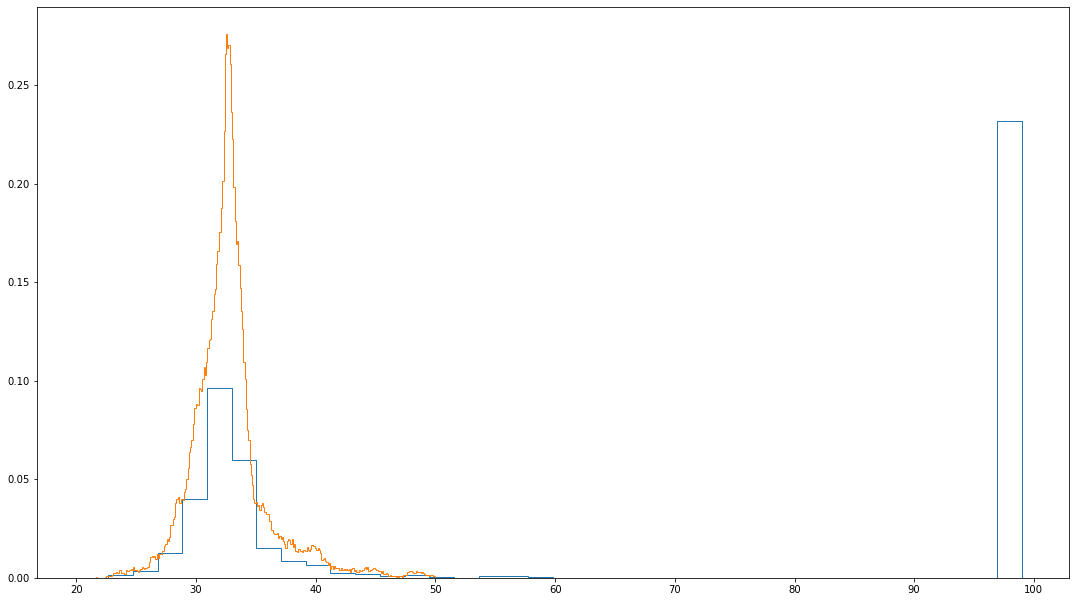

In [252]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
histogram(image_data, **hist_kwargs)
histogram(image_data[image_data < 50], **hist_kwargs)
# plt.ylim(0,0.5)

In [253]:
image_data_cropped = copy.deepcopy(image_data)

threshold_value = 50
image_data_cropped[image_data > threshold_value] = threshold_value

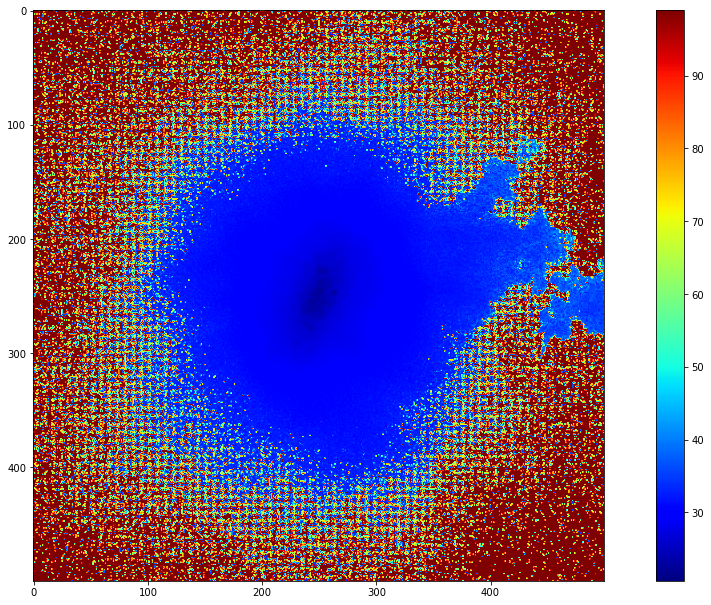

In [254]:
plot_image(image_data)

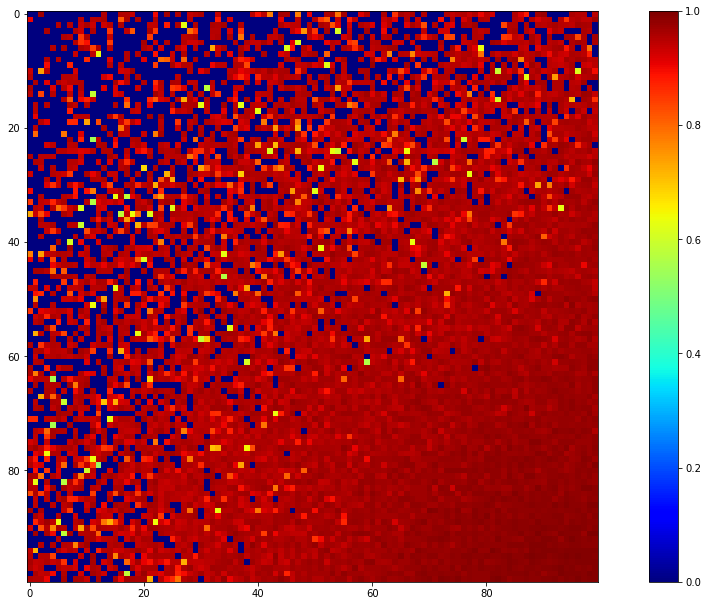

In [255]:
plot_image(invert_and_normalize(crop_to_square_image(image_data, 100, pos_x_init=100, pos_y_int=100)))

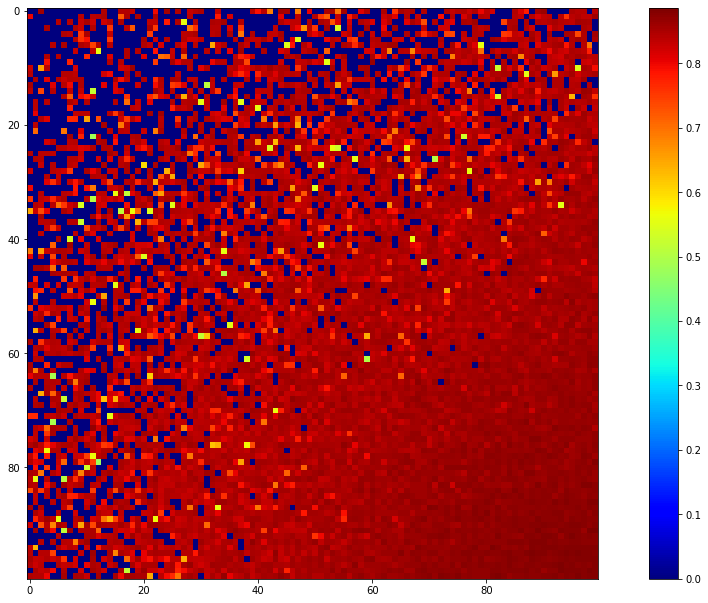

In [257]:
plot_image(crop_to_square_image(invert_and_normalize(image_data), 100, pos_x_init=100, pos_y_int=100))

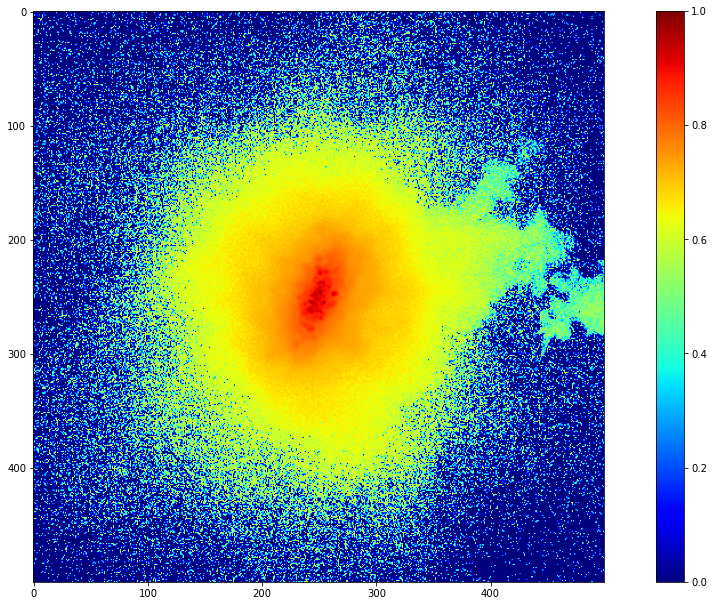

In [258]:
plot_image(invert_and_normalize(image_data_cropped))

In [259]:
from astropy.nddata import block_reduce, block_replicate
    
image_data = _fits.getdata(image_file, ext = 0)

# Open the image file
image_smaller = block_reduce(image_data, 1/0.3)


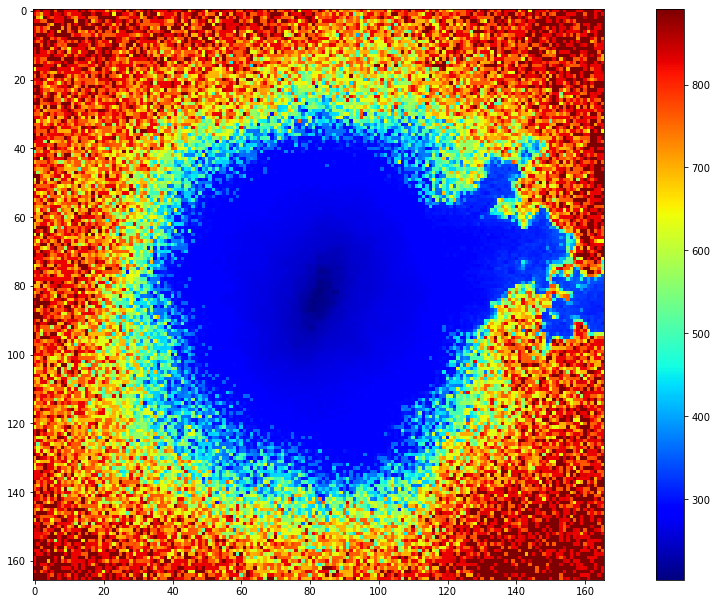

In [260]:
plot_image(image_smaller)

In [261]:
pixel_conversion = {}
pixel_conversion['HSC'] = 0.17 * astropy.units.arcsec # arcsec / pixel
pixel_conversion['JWST'] = 0.03 * astropy.units.arcsec # arcsec / pixel

In [262]:
from astropy.cosmology import Planck15

# Create an instance of the Planck 2015 cosmology
cosmo = Planck15

# Access various cosmological parameters
H0 = cosmo.H0  # Hubble constant in km/s/Mpc
Omega_m = cosmo.Om0  # Matter density parameter
Omega_lambda = cosmo.Ode0  # Dark energy density parameter

print("Hubble constant (H0):", H0)
print("Matter density parameter (Omega_m):", Omega_m)
print("Dark energy density parameter (Omega_lambda):", Omega_lambda)


Hubble constant (H0): 67.74 km / (Mpc s)
Matter density parameter (Omega_m): 0.3075
Dark energy density parameter (Omega_lambda): 0.6910098315260953


In [275]:
def arcsec_to_radian(x):
    return np.pi / 648000 * x

def radian_to_arcsec(x):
    return x / (np.pi / 648000)

def get_down_scale_factor(z = 0.2, unit_pixel_in_kpc = 0.1, experiment = 'HSC'):
    
    """
    Returns the scale factor at which the image has to be decreased for a given redshift. 
    
    
    """
    
    arcsec_per_kpc_at_z = Planck15.arcsec_per_kpc_proper(z)

    unit_pixel = unit_pixel_in_kpc * astropy.units.kpc
            
    down_scale_factor = 1 / unit_pixel * pixel_conversion[experiment] / arcsec_per_kpc_at_z
    
    if(down_scale_factor.unit == ''):
        return down_scale_factor.value
    else:
        raise "Error, factor carries a unit. "


def get_down_scale_factor_CHECK(z = 0.1, unit_pixel_in_kpc = 0.1, experiment = 'HSC'):
    
    distance = Planck15.angular_diameter_distance(z)
    
    distance_num_val = distance.value
    distance_unit = distance.unit

    if(distance_unit == 'Mpc'):
        distance_num_val *= 1000
    elif (distance_unit == 'kpc'):
        pass
    else:
        raise "Unit not known"
        
    angular_density_image = unit_pixel_in_kpc / distance_num_val
    print(angular_density_image)
    
    down_scale_factor = angular_density_image / arcsec_to_radian(pixel_conversion[experiment]) * astropy.units.arcsec
    
    return down_scale_factor


def get_downscaled_image_at_z(image_data, z, experiment = 'HSC'):
    
    reduce_factor = get_down_scale_factor(z, experiment = experiment)
    
    # Open the image file
    image_smaller = block_reduce(image_data, reduce_factor)
    
    return image_smaller
    
        
        

# Check the function against another computation

In [278]:
get_down_scale_factor(z = 0.2, experiment='HSC')

5.788855188387771

In [279]:
1 / get_down_scale_factor_CHECK(z = 0.2).value

1.4237413634728546e-07


5.78885518838777

# Compute an example image that is downsampled

In [290]:
image_data = _fits.getdata(image_file, ext = 0)
image_smaller = get_downscaled_image_at_z(image_data, 0.2)

5.788855188387771


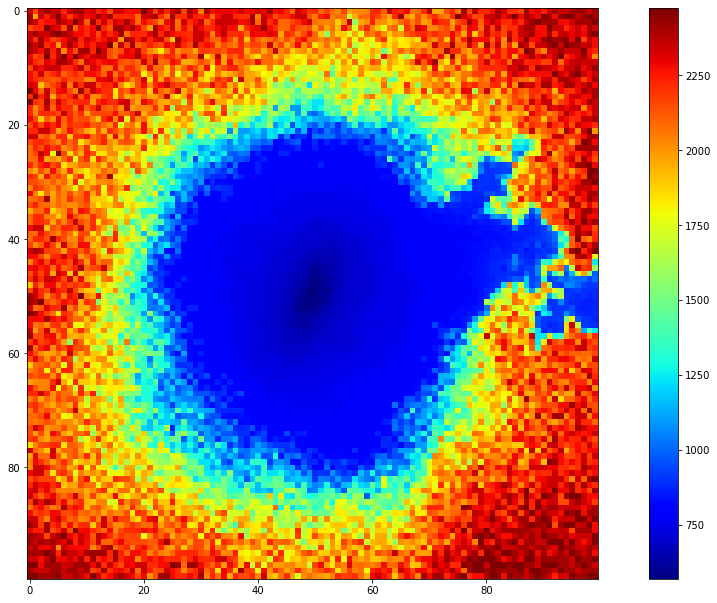

In [291]:
plot_image(image_smaller)